<a href="https://colab.research.google.com/github/Pratham-04/CS786A-Spring-2020-21/blob/main/Project/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a replication of the paper, 'Uncertainty and Exploration in a Restless Bandit Setting', Maarten Speekenbrink & Emmanouil Konstantinidis (2015). For the purpose of the project, only the few best-performing models will be fitted on the data.

In [14]:
!pip install pykalman
!pip install constrNMPy
!pip install numpy ssb_optimize

In [15]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import constrNMPy as cNM
import ssb_optimize.optimizer as opt1
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [16]:
def makeRew(trend, stable, clip, numTrials, s):
    # generates the game and returns those where each bandit is the best at least once
    np.random.seed(s)
    
    mus = []
    rews = []
    mu = np.array([-60, -20, 20, 60])
    np.random.shuffle(mu)
    mus.append(mu)
    sigma1 = 4
    decay = 0.9836
    
    kappas = np.zeros(4)
    if trend == 1:
        for i in range(len(mu)):
            if mu[i] == -60:
                kappas[i] = 0.5
            elif mu[i] == -20:
                kappas[i] = 0.5
            elif mu[i] == 20:
                kappas[i] = -0.5
            else:
                kappas[i] = -0.5
                
    sigma2 = 4        
    rews.append(np.random.normal(mu, sigma2))           
    for i in range(numTrials - 1):
        if stable == 0 and (51<=i<=100 or 151<=i<=200):
            sigma2 = 16
        else:
            sigma2 = 4
        mu = np.multiply(mu, decay)
        mu = np.add(mu, kappas)
        mu = np.random.normal(mu, sigma2)
        if clip == 1:
            mu = np.clip(mu, -100, 100)
        mus.append(mu)
        
        rew = np.random.normal(mu, sigma1)
        if clip == 1:
            rew = np.clip(rew, -100, 100)
        rews.append(rew)
    
    maxs = np.argmax(rews, 1)
    if ((0 in maxs) and (1 in maxs) and (2 in maxs) and (3 in maxs)):
        return np.array(mus), np.array(rews)
    else:
        return None, None

def kalman(rews, chosen_idx, mu0, sigma0, sigma_eps, sigma_xi):
    # takes as input a game and the policy used, returns the posterior means and variances of the arms
    # at each timestep
    numTrials = rews.shape[0]
    # print(numTrials)
    m = mu0*np.ones((numTrials+1, 4))
    v = sigma0*np.ones((numTrials+1, 4))
    for i in range(1, numTrials + 1):
        k_gain = np.zeros(4)
        k_gain[int(chosen_idx[i-1])] = (v[i-1, int(chosen_idx[i-1])] + sigma_xi**2)/(v[i-1, int(chosen_idx[i-1])] + sigma_xi**2 + sigma_eps**2)
        m[i] = m[i-1] + np.multiply(k_gain, rews[i-1] - m[i-1])
        v[i] = np.multiply(1 - k_gain, v[i-1] + sigma_xi**2)
    return m, v

def softmax(x, temp):
    # maps rewards to a (0,1) interval
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def kf_sm_neglik(param, rews, chosen_idx):
    # takes the game, used policy and hypothesis for input,
    # outputs the negative of log-likelihhod of the hypothesis
    numTrials = rews.shape[0]
    temp = param[0]
    mu0 = param[1] 
    sigma0 = param[2]
    sigma_eps = param[3]
    sigma_xi = param[4]
    m, v = kalman(rews, chosen_idx, mu0, sigma0, sigma_eps, sigma_xi)
    # x = pd.DataFrame(m, columns = [0,1,2,3])
    # x['choice'] = np.insert(chosen_idx, 0, 20)
    # print(x)
    loglik = 0
    for i in range(numTrials):
        prob = softmax(m[i+1], temp)
        # print(np.log(prob[int(chosen_idx[i])]))
        loglik += np.log(prob[int(chosen_idx[i])])
    # print(-loglik)
    return -loglik

def play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi):
    # plays the game with the parameters that are given input
    # uses Kalman Filter for learning anf softmax for choice
    numTrials = rews.shape[0]
    chosen_idx = -1*np.ones(numTrials)
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials+1, 4))
    for i in range(1, numTrials + 1):
        chosen_idx[i-1] = np.random.choice(np.array([0, 1, 2, 3]), 1, False, softmax(m[i-1], temp))
        k_gain = np.zeros(4)
        k_gain[int(chosen_idx[i-1])] = (v[i-1, int(chosen_idx[i-1])] + sigma_xi**2)/(v[i-1, int(chosen_idx[i-1])] + sigma_xi**2 + sigma_eps**2)
        m[i] = m[i-1] + np.multiply(k_gain, rews[i-1] - m[i-1])
        v[i] = np.multiply(1 - k_gain, v[i-1] + sigma_xi**2)
    return chosen_idx



In [17]:
# Generate game
# trend includes or excludes the constant drift in the rewards
# stable sets the volatility to high or low
# s is the seed for the rewards (selected previously)
numTrials = 200
trend = 0; stable = 1; clip = 0; s = 82
mus, rews = makeRew(trend, stable, clip, numTrials, s)
# fixing parameters
temp = 0.15; mu0 = 0; sigma0 = 1000; sigma_eps = 4; sigma_xi = 4
chosen_idx = play_kf_sm(rews, temp, mu0, sigma0, sigma_eps, sigma_xi)

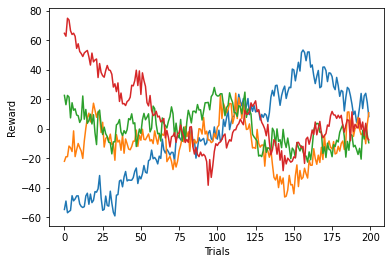

In [28]:
plt.plot(rews)
plt.xlabel('Trials')
plt.ylabel('Reward')
plt.show()

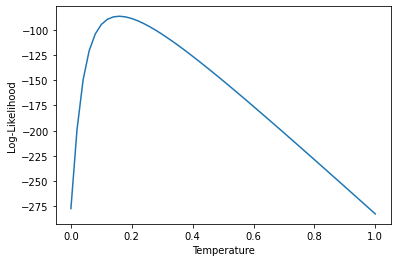

The maximum likelhood occurs at temp = 0.16


In [25]:
# Parameter extimation using maximum likelihood estimator
params_choice = np.linspace(0, 1, 51)
fin = []
for param_choice in np.nditer(params_choice):
    param = [param_choice, 0, 1000, 4, 4]
    fin.append(-1*kf_sm_neglik(param, rews, chosen_idx))
plt.plot(params_choice, fin)
plt.ylabel('Log-Likelihood')
plt.xlabel('Temperature')
plt.show()
print('The maximum likelhood occurs at temp = ' + str(params_choice[fin.index(max(fin))]))

In [26]:
# Parameter estimation using optimization - Bounded Nelder-Mead Simplex algorithm (as in the paper)
# temp = 0.5; mu0 = 0; sigma0 = 1000, sigma_eps = 4; sigma_xi = 4
LB = [0, 0, 0, 0, 0]
UB = [1, 5000, 5000, 5000, 5000]
param = np.array([0.5, 0.1, 1000, 4, 4])
cNM.constrNM(kf_sm_neglik, param, LB, UB, args = (rews, chosen_idx,), full_output = True)

{'allvecs': None,
 'fopt': 83.0734670415075,
 'funcalls': 341,
 'iter': 205,
 'warnflag': 0,
 'xopt': array([1.66526274e-01, 1.96215266e-08, 1.58340906e+03, 2.43793679e+01,
        9.63169025e+00])}

The optimum value of the temperature is at 0.166, which is close to the one obtained graphically.

Since the actual value is 0.15, the model provides a good enough fit for the data. Statistical criteria to evaluate fit will be used in the final analysis.



In [27]:
# # temp = 0.5; mu0 = 0; sigma0 = 1000, sigma_eps = 4; sigma_xi = 4
# bnds = [(0, 1), (0, 5000), (0, 5000), (0, 5000), (0, 5000)]
# bnds = opt1.bounds_check(len(bnds), bnds)
# param = [0.5, 0.1, 1000, 4, 4]
# minim = opt1.nelder_mead(param, kf_sm_neglik, bounds = bnds, args = (rews, chosen_idx,))
# print(minim)